In [13]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [14]:
sysinfo = pd.read_csv('./sysinfo.csv')

In [15]:
sysinfo.head()

,cpu_percent,temperature,timestamp
0,0.38,34,2017-05-24 18:41:53.875155
1,0.86,35,2017-05-24 18:42:53.879360
2,0.12,34,2017-05-24 18:43:53.883331
3,0.97,34,2017-05-24 18:44:53.887442
4,0.38,34,2017-05-24 18:45:53.891643


In [16]:
sysinfo.shape

(921, 3)

In [17]:
sysinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cpu_percent  921 non-null    float64
 1   temperature  921 non-null    int64  
 2   timestamp    921 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 21.7+ KB


Zamieniamy kolumnę timestamp z obiektu na...

In [18]:
sysinfo['timestamp'] = pd.to_datetime(sysinfo['timestamp'])

In [19]:
sysinfo.describe()

,cpu_percent,temperature,timestamp
count,921.000000,921.000000,921
mean,3.096927,33.689468,2017-05-25 02:21:55.746170112
min,0.000000,30.000000,2017-05-24 18:41:53.875155
25%,0.380000,32.000000,2017-05-24 22:31:54.801875968
50%,0.620000,32.000000,2017-05-25 02:21:55.659559936
75%,1.120000,33.000000,2017-05-25 06:11:56.583846912
max,100.000000,61.000000,2017-05-25 10:01:58.091661
std,9.083347,4.311157,NaN


Każda kolumna posiada taką samą ilość danych, co oznacza, że nie posiadamy żadnych brakujących informacji a naszym zbiorze

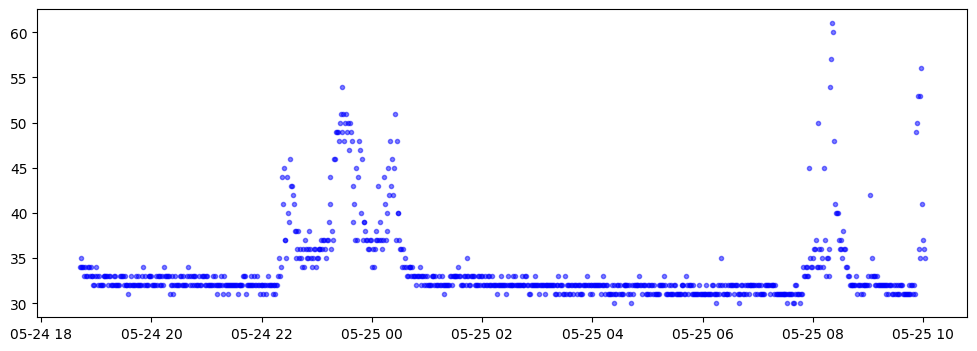

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(sysinfo['timestamp'], sysinfo['temperature'], 'b.', alpha=0.5)

# Las izolacyjny

In [21]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

/var/folders/90/tcq_7ztj1rv6z99l0zlswmx00000gn/T/ipykernel_16516/649786016.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sysinfo_without_timeseries['anomaly'] = model.predict(data)


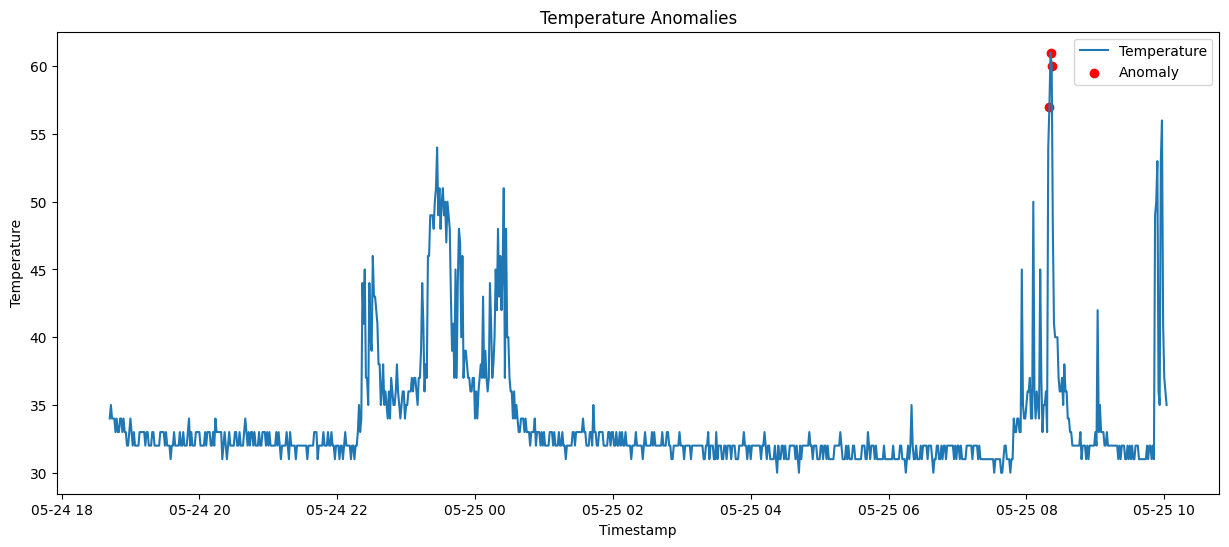

In [22]:
outliers_fraction = float(.003)
sysinfo_without_timeseries = sysinfo[list(set(sysinfo.columns) - {"timestamp", "cpu_percent"})]

scaler = StandardScaler()
np_scaled = scaler.fit_transform(sysinfo_without_timeseries.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)


model = IsolationForest(contamination=outliers_fraction)
model.fit(data) 


sysinfo_without_timeseries['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = sysinfo_without_timeseries.loc[sysinfo_without_timeseries['anomaly'] == -1, ['temperature']] #anomaly

ax.plot(sysinfo_without_timeseries.index, sysinfo_without_timeseries['temperature'], color='black', label = 'Normal')
ax.scatter(a.index,a['temperature'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

# HBOS

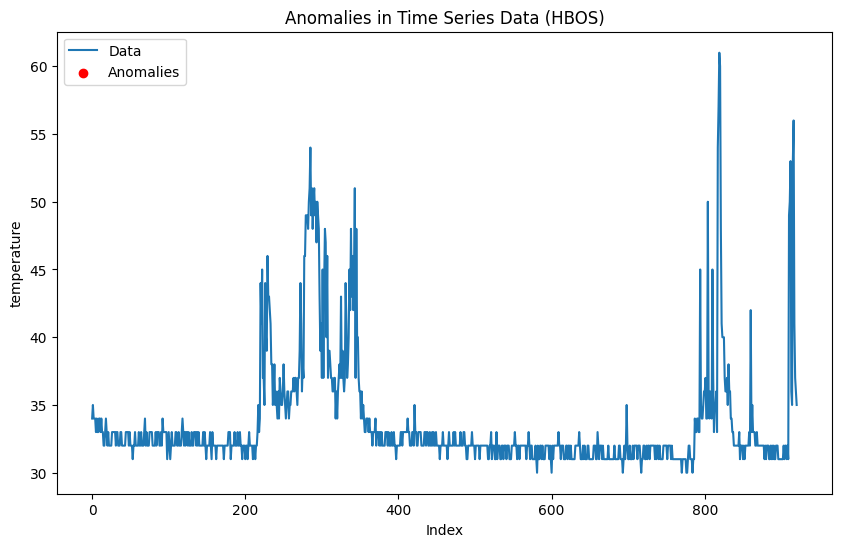

In [23]:
from pyod.models.hbos import HBOS

# Zakładamy, że sysinfo jest pandas DataFrame
# sysinfo = pd.DataFrame({...})  # tutaj wstaw swoje dane

# Wykluczenie kolumn "timestamp" i "cpu_percent" z danych
sysinfo_without_timeseries = sysinfo[list(set(sysinfo.columns) - {"timestamp", "cpu_percent"})]

# Inicjalizacja modelu HBOS
model = HBOS(contamination=0.003)

# Dopasowanie modelu do danych i predykcja anomalii
model.fit(sysinfo_without_timeseries)
predictions = model.predict(sysinfo_without_timeseries)

# Stworzenie DataFrame z oryginalnych danych (bez "timestamp" i "cpu_percent")
time_series_data = pd.DataFrame(sysinfo_without_timeseries)

# Dodanie kolumny "Anomaly" do DataFrame, gdzie 1 oznacza anomalię, a 0 normalny punkt
time_series_data['Anomaly'] = predictions

# Wyświetlenie wszystkich wierszy, które są anomaliami
anomalies = time_series_data[time_series_data['Anomaly'] == 1]

# Wizualizacja wyników
plt.figure(figsize=(10, 6))

# Jeśli masz więcej niż jedną kolumnę w sysinfo_without_timeseries, użyj tylko jednej kolumny do wizualizacji
# Na przykład, zakładając, że pierwsza kolumna to ta, którą chcesz wykres:
column_name = sysinfo_without_timeseries.columns[0]

# Wykres wszystkich danych
plt.plot(time_series_data.index, time_series_data[column_name], label='Data')

# Wykres anomalii
plt.scatter(anomalies.index, anomalies[column_name], color='red', label='Anomalies')

plt.xlabel('Index')
plt.ylabel(column_name)
plt.title('Anomalies in Time Series Data (HBOS)')
plt.legend()
plt.show()


# K-means

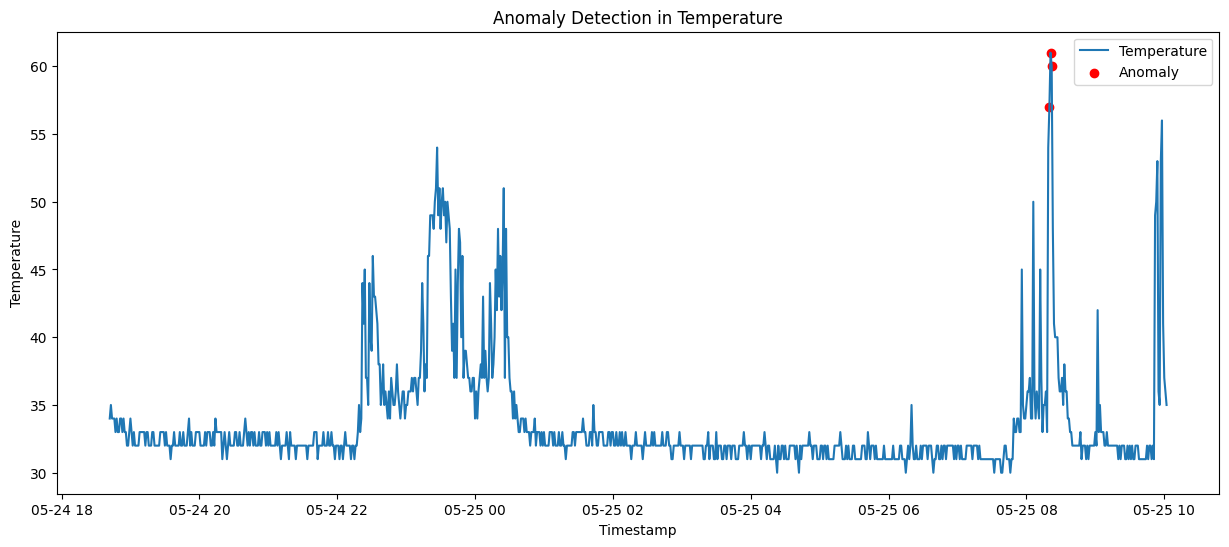

In [24]:
from sklearn.cluster import KMeans
import numpy as np

data = pd.read_csv('./sysinfo.csv')

# Przetwarzanie kolumny timestamp na typ daty
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Wykorzystanie K-means do klasteryzacji
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[['temperature']])

# Obliczenie odległości od centrum klastra
data['distance'] = np.linalg.norm(data[['temperature']] - kmeans.cluster_centers_[data['cluster']], axis=1)

# Wyznaczenie progu anomalii (np. percentyl 95)
threshold = np.percentile(data['distance'], 99.7)
data['anomaly'] = (data['distance'] > threshold).astype(int)

plt.figure(figsize=(15, 6))
plt.plot(data['timestamp'], data['temperature'], label='Temperature')
plt.scatter(data['timestamp'][data['anomaly'] == 1], data['temperature'][data['anomaly'] == 1], color='red', label='Anomaly')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Anomaly Detection in Temperature')
plt.legend()
plt.show()